In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
def rearrange_data(X, Y):
    new_X = []
    new_Y = []
    for i in range(len(X)):
        for j in range(len(X)):
            new_X.append(np.array([*X[i], *X[j]]))
            new_Y.append(Y[i] - Y[j])
    return new_X, new_Y

In [3]:
def tnnr(f, ranges=[(-10, 10, 1)], title_text='$f(x)$', learning_rate=1e-2, model=None):
    
    input_vars = len(ranges)
    
    # create data for training from the function
    train_data = []
    for i in range(input_vars):
        train_data.append(np.array(np.arange(ranges[i][0], ranges[i][1], ranges[i][2]), dtype=np.float32))
    train_data = np.meshgrid(*train_data)
    train_data_y = f(train_data)
    train_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in train_data])
    train_data_y_model = train_data_y.flatten()
    train_data_model, train_data_y_model = rearrange_data(train_data_model, train_data_y_model)
    train_data_model = np.array(train_data_model, dtype=np.float32)
    train_data_y_model = np.array(train_data_y_model, dtype=np.float32)
    print(train_data_model.shape)
    print(train_data_y_model.shape)
    
    # create data for validating from the function
    val_data = []
    for i in range(input_vars):
        val_data.append(np.array(np.arange(ranges[i][0], ranges[i][1], ranges[i][2] - 0.008), dtype=np.float32))
    val_data = np.meshgrid(*val_data)
    val_data_y = f(val_data)
    val_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in val_data])
    val_data_y_model = val_data_y.flatten()
    val_data_model, val_data_y_model = rearrange_data(val_data_model, val_data_y_model)
    val_data_model = np.array(val_data_model, dtype=np.float32)
    val_data_y_model = np.array(val_data_y_model, dtype=np.float32)
    print(val_data_model.shape)
    print(val_data_y_model.shape)
    
    # define model
    if model is None:
        # default model is: 1, 64, 64, 1
        model = model_1_64_64_1(input_vars=input_vars*2)
    
    optimizer = Adadelta(learning_rate=learning_rate)

    # compile model: the model is initialized with the Adadelta optimizer
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # patience early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

    # fit the model
    history = model.fit(train_data_model, train_data_y_model, validation_data=(val_data_model, val_data_y_model), 
                        epochs=10000000, batch_size=100, verbose=0, callbacks=[es])

    # calculate predictions
    pred_train_set = model.predict(train_data_model)
    pred_val_set = model.predict(val_data_model)
    
    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.title('Training history')
    plt.xlabel('Epoch')
    plt.ylabel('Validation loss')
    plt.show()
    
    # plot actual vs prediction for training set
    plt.plot(train_data_y_model, pred_train_set, 'bo')
    plt.title('Training set')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # compute R-Square value for training set
    test_r2_value = r2_score(train_data_y_model, pred_train_set)
    print("Training Set R-Square=", test_r2_value)
    
    # plot both original function and predicted
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(train_data_model[:,0], train_data_model[:,1], train_data_y_model, 
               label='True data', c='blue', alpha=0.3)
    ax.scatter(train_data_model[:,0], train_data_model[:,1], 
               np.reshape(pred_train_set.flatten(), train_data_y_model.shape), 
               label='Predictions', c='orange', alpha=0.7)
    ax.legend()
    ax.set_xlabel('$x_i$')
    ax.set_ylabel('$x_j$')
    ax.set_zlabel('$F(x_i, x_j)$')
    ax.set_title('Function: ' + title_text)
    plt.show()
    
    return train_data_model, train_data_y_model, pred_train_set, model

In [4]:
# to make comparisons

def ann(f_ann, ranges=[(-10, 10, 1)], learning_rate=1e-2, model_ann=None):

    input_vars = len(ranges)

    # create data for training from the function
    train_data = []
    for i in range(input_vars):
        train_data.append(np.array(np.arange(ranges[i][0], ranges[i][1], ranges[i][2]), dtype=np.float32))
    train_data = np.meshgrid(*train_data)
    train_data_y = f_ann(train_data)
    train_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in train_data])
    train_data_y_model = train_data_y.flatten()
    print(train_data_model.shape)
    print(train_data_y_model.shape)

    # create data for validating from the function
    val_data = []
    for i in range(input_vars):
        val_data.append(np.array(np.arange(ranges[i][0], ranges[i][1], ranges[i][2] - 0.008), dtype=np.float32))
    val_data = np.meshgrid(*val_data)
    val_data_y = f_ann(val_data)
    val_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in val_data])
    val_data_y_model = val_data_y.flatten()
    print(val_data_model.shape)
    print(val_data_y_model.shape)

    # define model
    if model_ann is None:
        # default model is: 1, 64, 64, 1
        model_ann = model_1_64_64_1(input_vars=input_vars)

    optimizer = Adadelta(learning_rate=learning_rate)

    # compile model: the model is initialized with the Adam optimizer
    model_ann.compile(loss='mean_squared_error', optimizer=optimizer)

    # patience early stopping
    es_ann = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

    # fit the model
    history_ann = model_ann.fit(train_data_model, train_data_y_model, 
                                validation_data=(val_data_model, val_data_y_model), 
                                epochs=10000000, batch_size=100, verbose=0, callbacks=[es_ann])

    return model_ann

In [5]:
def model_1_64_64_1(input_vars=1):
    model = Sequential()
    model.add(Dense(64, activation="relu", input_dim=input_vars))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return model
    
def model_1_128_128_1(input_vars=1):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=input_vars))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return model

def model_1_128_32_8_1(input_vars=1):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=input_vars))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return model

# Function $\mathbb{R} \rightarrow \mathbb{R}$

# $f(x) = -2x^5 - x^4 + 3x^3 + \sin(x)$

In [6]:
f = lambda varss: -2*varss[0]**5 - varss[0]**4 + 3*varss[0]**3 + np.sin(varss[0])

In [7]:
function_text = '$-2x^5 - x^4 + 3x^3 + \sin(x)$'

In [8]:
x_data = [[i] for i in np.arange(-10, 10, 0.1)]
y_data = [f(i) for i in x_data]

Text(0, 0.5, 'f(x)')

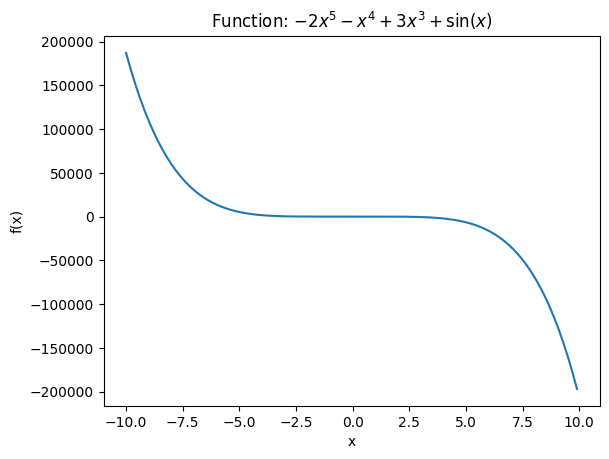

In [9]:
plt.plot(x_data, y_data)
plt.title('Function: ' + function_text)
plt.xlabel('x')
plt.ylabel('f(x)')

## 40 training points, 50 testing points

In [10]:
ranges_train = [(-10, 10, 0.5)]
ranges_test = [(-10, 10, 0.4)]

### Layers: 1, 64, 64, 1

(1600, 2)
(1600,)
(1681, 2)
(1681,)
Epoch 7567: early stopping
53/53 [==============================] - 0s 246us/step


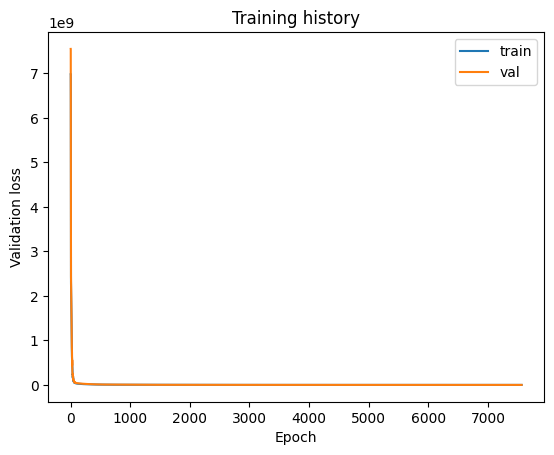

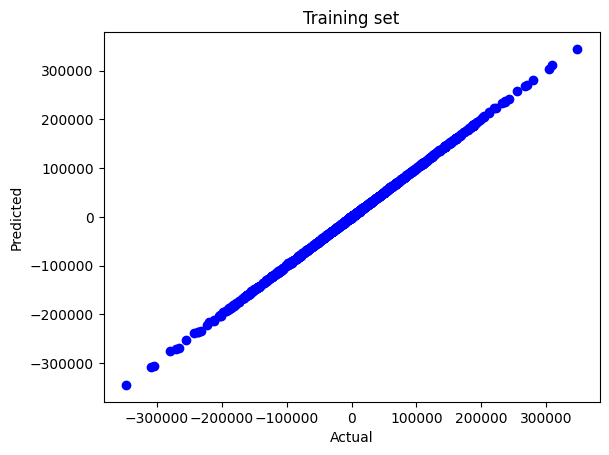

Training Set R-Square= 0.9999550519063792


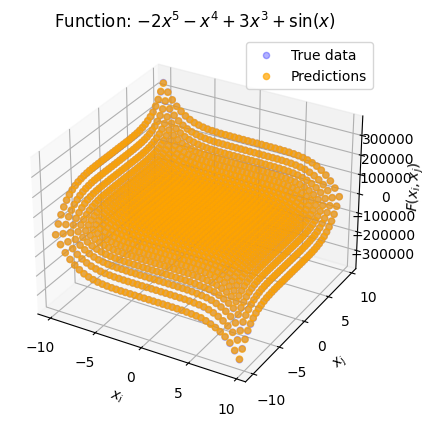

CPU times: user 2min 10s, sys: 25 s, total: 2min 35s
Wall time: 1min 55s


In [13]:
%%time

train_data, train_data_y, pred_train_set, model = tnnr(f, ranges=ranges_train, 
                                                       title_text='$-2x^5 - x^4 + 3x^3 + \sin(x)$',
                                                       learning_rate=1)

63/63 [==============================] - 0s 252us/step


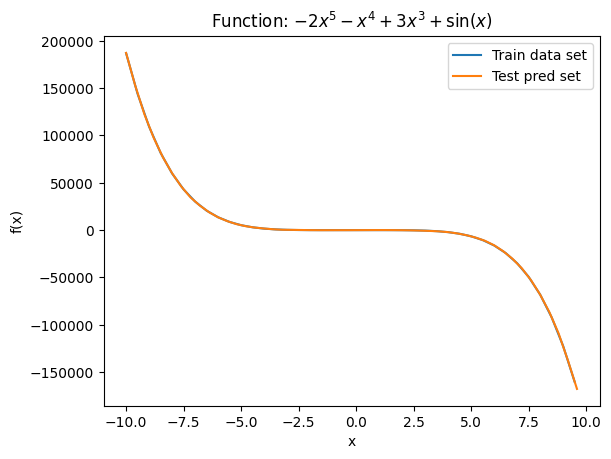

In [14]:
# Calculate y_pred

# generate test data

test_data = np.array(np.arange(ranges_test[0][0], ranges_test[0][1], ranges_test[0][2]), dtype=np.float32)

# train data
X_train = np.array(np.arange(ranges_train[0][0], ranges_train[0][1], ranges_train[0][2]), dtype=np.float32)
Y_train = np.array([f([i]) for i in X_train], dtype=np.float32)

# combine with train data

X_test = []

for i in range(len(test_data)):
    for j in range(len(X_train)):
        X_test.append(np.array([test_data[i], X_train[j]]))
        
X_test = np.array(X_test, dtype=np.float32)


pred_test_set = model.predict(X_test)

y_pred = []
pred_i = 0
for i in range(len(test_data)):
    suma = 0
    for j in range(len(X_train)):
        suma += pred_test_set[pred_i] + Y_train[j]
        pred_i += 1
    y_pred.append(suma/len(X_train))

    
plt.plot(X_train, Y_train, label='Train data set')
plt.plot(test_data, y_pred, label='Test pred set')
plt.title('Function: ' + function_text)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

In [15]:
%%time

model_ann = ann(f, ranges=ranges_train, learning_rate=1)

(40, 1)
(40,)
(41, 1)
(41,)
Epoch 1901: early stopping
CPU times: user 14.8 s, sys: 2.41 s, total: 17.2 s
Wall time: 14.3 s


2/2 [==============================] - 0s 1ms/step


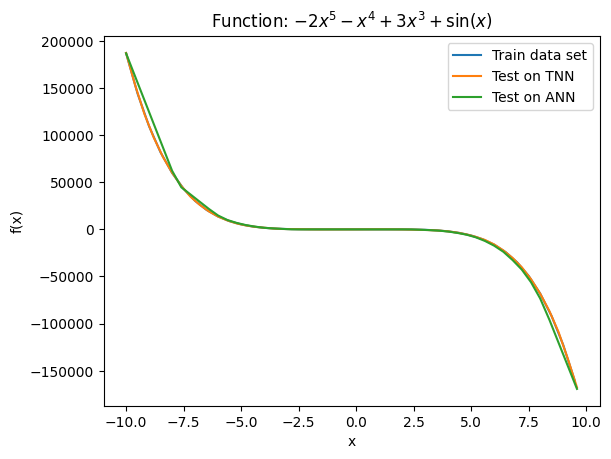

In [16]:
y_pred_ann = model_ann.predict(test_data)

plt.plot(X_train, Y_train, label='Train data set')
plt.plot(test_data, y_pred, label='Test on TNN')
plt.plot(test_data, y_pred_ann, label='Test on ANN')
plt.title('Function: ' + function_text)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

In [17]:
tnn_rmse = mean_squared_error(np.array([f([i]) for i in test_data], dtype=np.float32), 
                              y_pred,
                              squared=False)

ann_rmse = mean_squared_error(np.array([f([i]) for i in test_data], dtype=np.float32), 
                              y_pred_ann,
                              squared=False)

print('RMSE for TNN =', tnn_rmse)
print('RMSE for ANN =', ann_rmse)

RMSE for TNN = 233.09064
RMSE for ANN = 4421.9624


### Layers: 1, 128, 128, 1

(1600, 2)
(1600,)
(1681, 2)
(1681,)
Epoch 4642: early stopping
53/53 [==============================] - 0s 231us/step


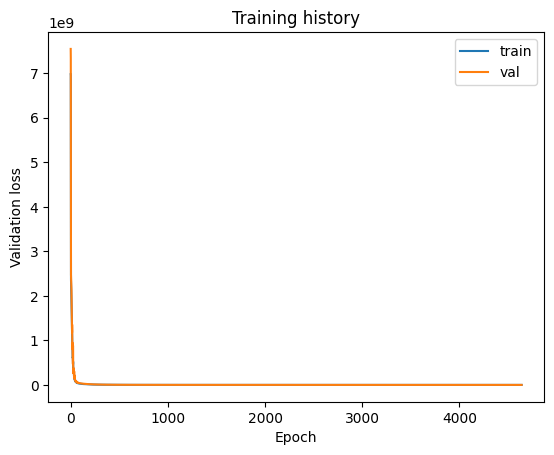

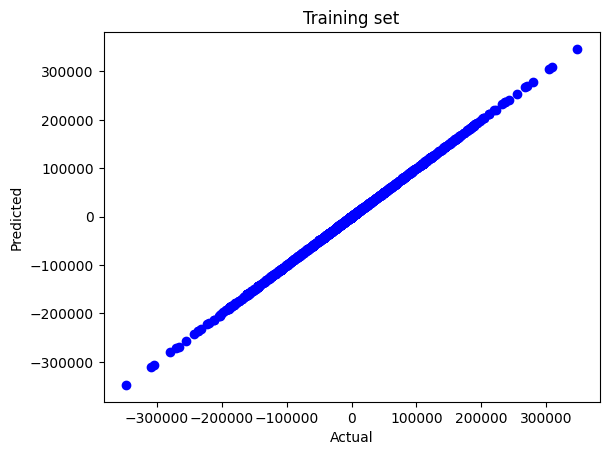

Training Set R-Square= 0.9999828796497888


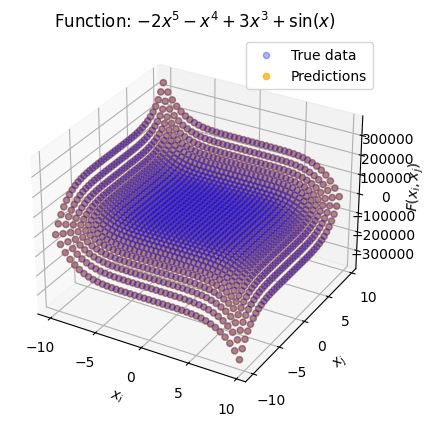

CPU times: user 1min 50s, sys: 42.4 s, total: 2min 33s
Wall time: 1min 25s


In [18]:
%%time

train_data, train_data_y, pred_train_set, model = tnnr(f, ranges=ranges_train, 
                                                       title_text='$-2x^5 - x^4 + 3x^3 + \sin(x)$',
                                                       learning_rate=1,
                                                       model=model_1_128_128_1(input_vars=len(ranges_train)*2))

In [19]:
# Calculate y_pred

# generate test data

test_data = np.array(np.arange(ranges_test[0][0], ranges_test[0][1], ranges_test[0][2]), dtype=np.float32)

# train data
X_train = np.array(np.arange(ranges_train[0][0], ranges_train[0][1], ranges_train[0][2]), dtype=np.float32)
Y_train = np.array([f([i]) for i in X_train], dtype=np.float32)

# combine with train data

X_test = []

for i in range(len(test_data)):
    for j in range(len(X_train)):
        X_test.append(np.array([test_data[i], X_train[j]]))
        
X_test = np.array(X_test, dtype=np.float32)


pred_test_set = model.predict(X_test)

y_pred = []
pred_i = 0
for i in range(len(test_data)):
    suma = 0
    for j in range(len(X_train)):
        suma += pred_test_set[pred_i] + Y_train[j]
        pred_i += 1
    y_pred.append(suma/len(X_train))


63/63 [==============================] - 0s 268us/step


In [20]:
%%time

model_ann = ann(f, ranges=ranges_train, learning_rate=1, model_ann=model_1_128_128_1(input_vars=len(ranges_train)))

(40, 1)
(40,)
(41, 1)
(41,)
Epoch 3519: early stopping
CPU times: user 27.9 s, sys: 5.45 s, total: 33.3 s
Wall time: 27.1 s


2/2 [==============================] - 0s 1ms/step


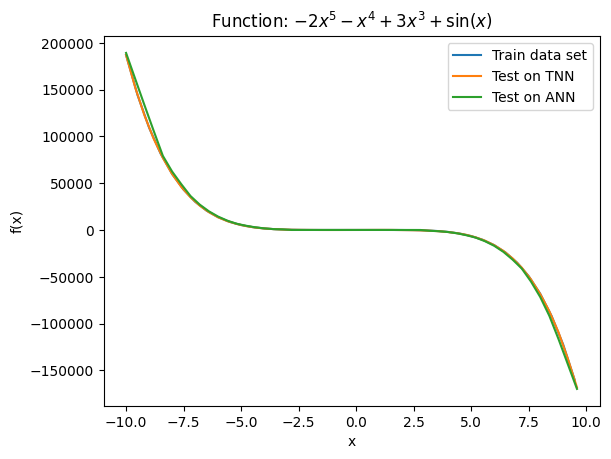

In [21]:
y_pred_ann = model_ann.predict(test_data)

plt.plot(X_train, Y_train, label='Train data set')
plt.plot(test_data, y_pred, label='Test on TNN')
plt.plot(test_data, y_pred_ann, label='Test on ANN')
plt.title('Function: ' + function_text)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

In [22]:
tnn_rmse = mean_squared_error(np.array([f([i]) for i in test_data], dtype=np.float32), 
                              y_pred,
                              squared=False)

ann_rmse = mean_squared_error(np.array([f([i]) for i in test_data], dtype=np.float32), 
                              y_pred_ann,
                              squared=False)

print('RMSE for TNN =', tnn_rmse)
print('RMSE for ANN =', ann_rmse)

RMSE for TNN = 151.38239
RMSE for ANN = 3019.5574


# Function $\mathbb{R}^2 \rightarrow \mathbb{R}$

# $g(x) = x^2 + y^3 - 3xy$

In [23]:
g = lambda varss: varss[0]**2 + varss[1]**3 - 3*varss[0]*varss[1]

In [24]:
x_data = np.arange(-10, 10, 0.1)
y_data = np.arange(-10, 10, 0.1)
x_data, y_data = np.meshgrid(x_data, y_data)
z_data = g([x_data, y_data])

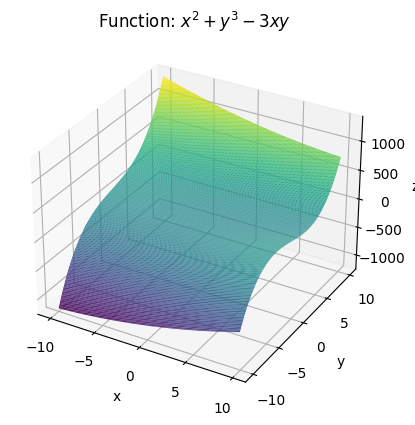

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x_data, y_data, z_data, rstride=1, cstride=1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Function: $x^2 + y^3 - 3 x y$');

## 40 training points, 50 testing points

In [26]:
ranges_train = [(-10, 10, 2), (-10, 10, 2)]
ranges_test = [(-10, 10, 1.4), (-10, 10, 1.4)]

### Layers: 1, 64, 64, 1

(10000, 4)
(10000,)
(14641, 4)
(14641,)
Epoch 705: early stopping
458/458 [==============================] - 0s 205us/step


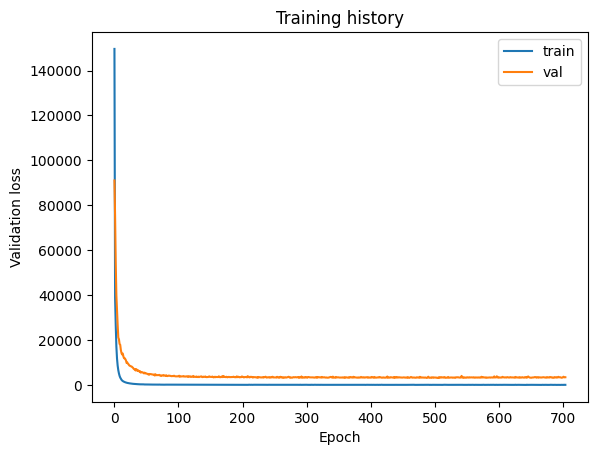

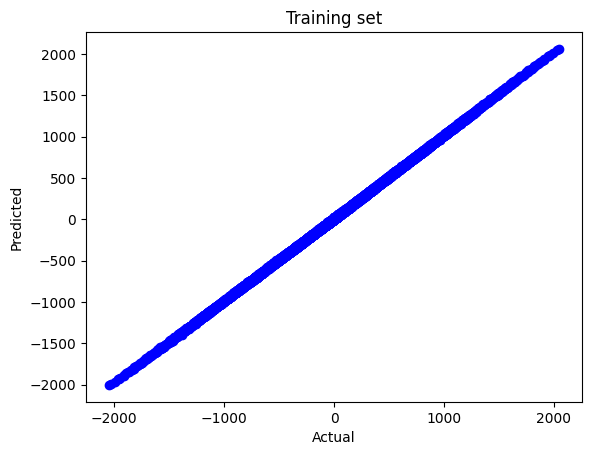

Training Set R-Square= 0.9996802173074498


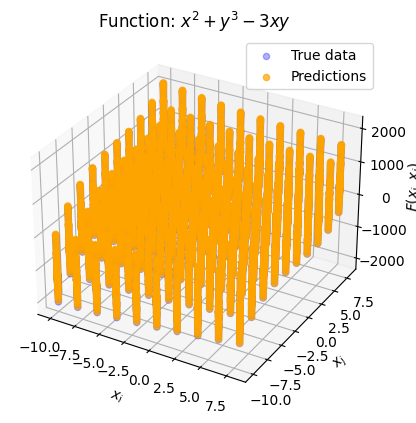

CPU times: user 57.6 s, sys: 9.37 s, total: 1min 7s
Wall time: 46.8 s


In [27]:
%%time

train_data, train_data_y, pred_train_set, model = tnnr(g, ranges=ranges_train, 
                                                       title_text='$x^2 + y^3 - 3 x y$',
                                                       learning_rate=1)

In [28]:
# train data

input_vars = len(ranges_train)

train_data = []
for i in range(input_vars):
    train_data.append(np.array(np.arange(ranges_train[i][0], 
                                         ranges_train[i][1], ranges_train[i][2]), dtype=np.float32))
train_data = np.meshgrid(*train_data)
train_data_y = g(train_data)
train_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in train_data])
train_data_y_model = train_data_y.flatten()
#train_data_model, train_data_y_model = rearrange_data(train_data_model, train_data_y_model)
train_data_model = np.array(train_data_model, dtype=np.float32)
train_data_y_model = np.array(train_data_y_model, dtype=np.float32)

print(train_data_model.shape)
print(train_data_y_model.shape)


# generate test data

test_data = []
for i in range(input_vars):
    test_data.append(np.array(np.arange(ranges_test[i][0], ranges_test[i][1], ranges_test[i][2]), dtype=np.float32))
test_data = np.meshgrid(*test_data)
test_data_y = g(test_data)
test_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in test_data])
test_data_y_model = test_data_y.flatten()
#test_data_model, test_data_y_model = rearrange_data(test_data_model, test_data_y_model)
test_data_model = np.array(test_data_model, dtype=np.float32)
test_data_y_model = np.array(test_data_y_model, dtype=np.float32)

print(test_data_model.shape)
print(test_data_y_model.shape)

(100, 2)
(100,)
(225, 2)
(225,)


704/704 [==============================] - 0s 207us/step


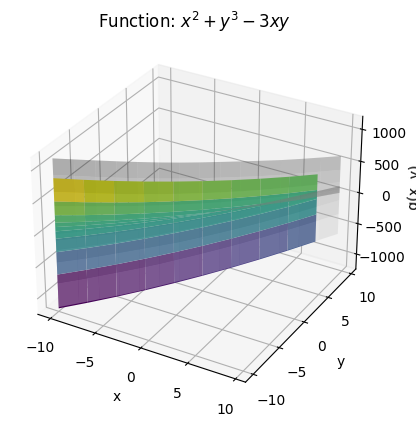

In [29]:
# Calculate y_pred

# combine with train data

X_test = []

for i in range(len(test_data_model)):
    for j in range(len(train_data_model)):
        X_test.append(np.concatenate((test_data_model[i], train_data_model[j])))
        
X_test = np.array(X_test, dtype=np.float32)


pred_test_set = model.predict(X_test)

y_pred = []
pred_i = 0
for i in range(len(test_data_model)):
    suma = 0
    for j in range(len(train_data_model)):
        suma += pred_test_set[pred_i] + train_data_y_model[j]
        pred_i += 1
    y_pred.append(suma/len(train_data_model))


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(train_data[0][0], train_data[1][:,0], np.reshape(train_data_y_model, (10,10)), 
                rstride=1, cstride=1, cmap='viridis', alpha=1)
ax.plot_surface(test_data[0][0], test_data[1][:,0], np.reshape(y_pred, (15,15)), 
                rstride=1, cstride=1, cmap='binary', alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('g(x, y)')
ax.set_title('Function: $x^2 + y^3 - 3 x y$');

In [30]:
%%time

model_ann = ann(g, ranges=ranges_train, learning_rate=1)

(100, 2)
(100,)
(121, 2)
(121,)
Epoch 1546: early stopping
CPU times: user 13 s, sys: 2.05 s, total: 15 s
Wall time: 12.4 s


8/8 [==============================] - 0s 416us/step


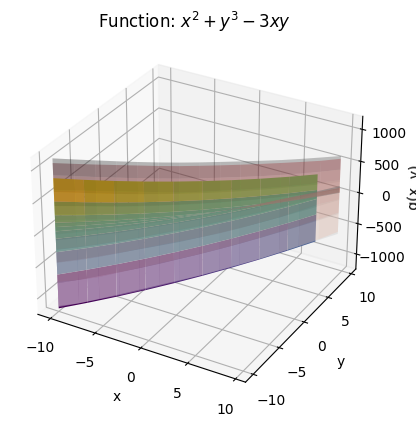

In [31]:
y_pred_ann = model_ann.predict(test_data_model)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(train_data[0][0], train_data[1][:,0], np.reshape(train_data_y_model, (10,10)), 
                rstride=1, cstride=1, cmap='viridis', alpha=1)
ax.plot_surface(test_data[0][0], test_data[1][:,0], np.reshape(y_pred, (15,15)), 
                rstride=1, cstride=1, cmap='binary', alpha=0.3)
ax.plot_surface(test_data[0][0], test_data[1][:,0], np.reshape(y_pred_ann, (15,15)), 
                rstride=1, cstride=1, cmap='Reds', alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('g(x, y)')
ax.set_title('Function: $x^2 + y^3 - 3 x y$');

In [32]:
tnn_rmse = mean_squared_error(np.array([g(i) for i in test_data_model], dtype=np.float32), 
                              y_pred,
                              squared=False)

ann_rmse = mean_squared_error(np.array([g(i) for i in test_data_model], dtype=np.float32), 
                              y_pred_ann,
                              squared=False)

print('RMSE for TNN =', tnn_rmse)
print('RMSE for ANN =', ann_rmse)

RMSE for TNN = 24.60708
RMSE for ANN = 40.351852


### Layers: 1, 128, 128, 1

(10000, 4)
(10000,)
(14641, 4)
(14641,)
Epoch 613: early stopping
458/458 [==============================] - 0s 216us/step


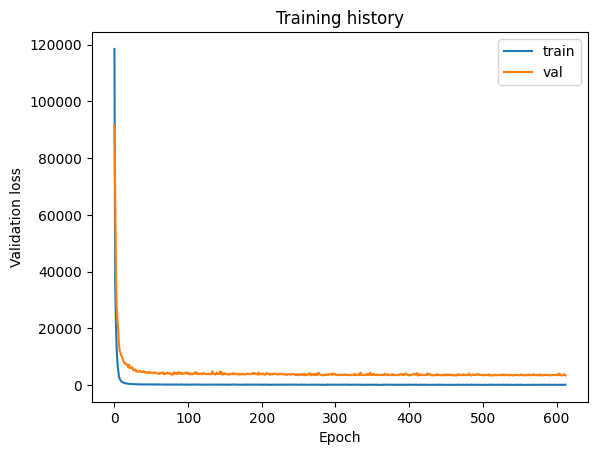

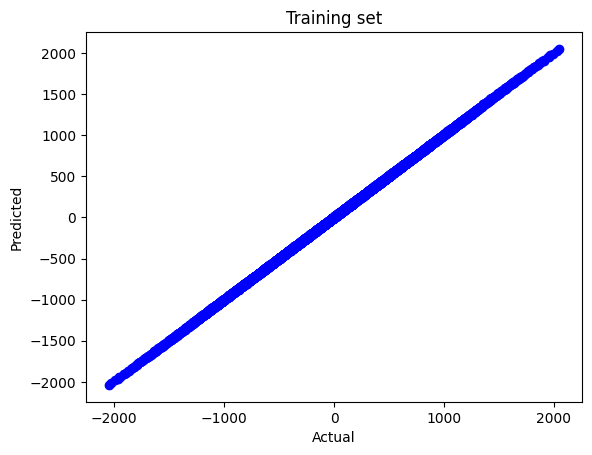

Training Set R-Square= 0.9999625047519773


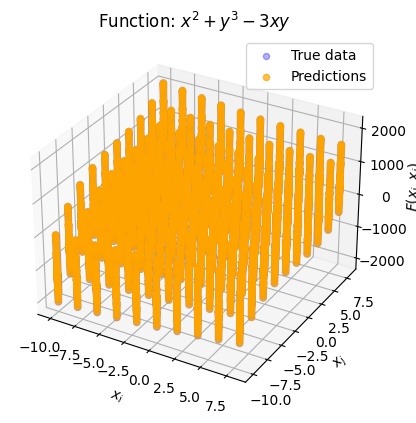

CPU times: user 1min 16s, sys: 30.9 s, total: 1min 46s
Wall time: 55.5 s


In [33]:
%%time


train_data, train_data_y, pred_train_set, model = tnnr(g, ranges=ranges_train, 
                                                       title_text='$x^2 + y^3 - 3 x y$',
                                                       learning_rate=1,
                                                       model=model_1_128_128_1(input_vars=len(ranges_train)*2))

In [34]:
# train data

input_vars = len(ranges_train)

train_data = []
for i in range(input_vars):
    train_data.append(np.array(np.arange(ranges_train[i][0], 
                                         ranges_train[i][1], ranges_train[i][2]), dtype=np.float32))
train_data = np.meshgrid(*train_data)
train_data_y = g(train_data)
train_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in train_data])
train_data_y_model = train_data_y.flatten()
#train_data_model, train_data_y_model = rearrange_data(train_data_model, train_data_y_model)
train_data_model = np.array(train_data_model, dtype=np.float32)
train_data_y_model = np.array(train_data_y_model, dtype=np.float32)

print(train_data_model.shape)
print(train_data_y_model.shape)


# generate test data

test_data = []
for i in range(input_vars):
    test_data.append(np.array(np.arange(ranges_test[i][0], ranges_test[i][1], ranges_test[i][2]), dtype=np.float32))
test_data = np.meshgrid(*test_data)
test_data_y = g(test_data)
test_data_model = np.hstack([v.flatten().reshape(-1, 1) for v in test_data])
test_data_y_model = test_data_y.flatten()
#test_data_model, test_data_y_model = rearrange_data(test_data_model, test_data_y_model)
test_data_model = np.array(test_data_model, dtype=np.float32)
test_data_y_model = np.array(test_data_y_model, dtype=np.float32)

print(test_data_model.shape)
print(test_data_y_model.shape)



# Calculate y_pred

# combine with train data

X_test = []

for i in range(len(test_data_model)):
    for j in range(len(train_data_model)):
        X_test.append(np.concatenate((test_data_model[i], train_data_model[j])))
        
X_test = np.array(X_test, dtype=np.float32)


pred_test_set = model.predict(X_test)

y_pred = []
pred_i = 0
for i in range(len(test_data_model)):
    suma = 0
    for j in range(len(train_data_model)):
        suma += pred_test_set[pred_i] + train_data_y_model[j]
        pred_i += 1
    y_pred.append(suma/len(train_data_model))


(100, 2)
(100,)
(225, 2)
(225,)
704/704 [==============================] - 0s 210us/step


In [35]:
%%time

model_ann = ann(g, ranges=ranges_train, learning_rate=1, model_ann=model_1_128_128_1(input_vars=len(ranges_train)))

(100, 2)
(100,)
(121, 2)
(121,)
Epoch 2960: early stopping
CPU times: user 24.6 s, sys: 5.34 s, total: 29.9 s
Wall time: 23.7 s


8/8 [==============================] - 0s 407us/step


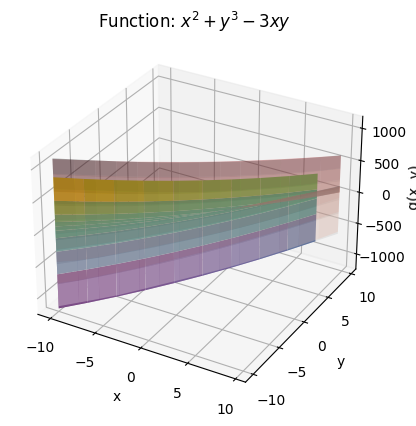

In [36]:
y_pred_ann = model_ann.predict(test_data_model)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(train_data[0][0], train_data[1][:,0], np.reshape(train_data_y_model, (10,10)), 
                rstride=1, cstride=1, cmap='viridis', alpha=1)
ax.plot_surface(test_data[0][0], test_data[1][:,0], np.reshape(y_pred, (15,15)), 
                rstride=1, cstride=1, cmap='binary', alpha=0.3)
ax.plot_surface(test_data[0][0], test_data[1][:,0], np.reshape(y_pred_ann, (15,15)), 
                rstride=1, cstride=1, cmap='Reds', alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('g(x, y)')
ax.set_title('Function: $x^2 + y^3 - 3 x y$');

In [37]:
tnn_rmse = mean_squared_error(np.array([g(i) for i in test_data_model], dtype=np.float32), 
                              y_pred,
                              squared=False)

ann_rmse = mean_squared_error(np.array([g(i) for i in test_data_model], dtype=np.float32), 
                              y_pred_ann,
                              squared=False)

print('RMSE for TNN =', tnn_rmse)
print('RMSE for ANN =', ann_rmse)

RMSE for TNN = 26.350338
RMSE for ANN = 29.62587
